In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, mannwhitneyu
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

In [2]:
# function for splitting the dataset indices into training (75%) and testing (25%) sets
def select_indices_percent(data, train_frac=0.75, shuffle=True):
    indices = np.arange(len(data))
    
    if shuffle:
        np.random.seed(42)
        np.random.shuffle(indices)
    
    split = int(len(indices) * train_frac)
    train_indices = indices[:split]
    test_indices = indices[split:]
    return train_indices, test_indices


# function for splitting the dataset indices into training and testing (station) sets
def select_indices_station(data, train_station, test_station):
    train_indices = np.array(data.loc[data.station == train_station].index)
    test_indices = np.array(data.loc[data.station == test_station].index)
    return train_indices, test_indices


# function for making the train and test sets
def make_train_test_sets(data, predictors, train_indices, test_indices, log_transf_n100 = False, print_shapes=False):
    # predictor variables
    X_train = np.array(np.take(data[predictors], train_indices, 0))
    X_test = np.array(np.take(data[predictors], test_indices, 0))

    # n100 concentration
    y_train = None
    y_test = None
    log_y_test = np.array(np.take(data.n100_log, test_indices, 0))
    orig_y_test = np.array(np.take(data.n100, test_indices, 0))

    if not log_transf_n100:
        y_train = np.array(np.take(data.n100, train_indices, 0))
        y_test = orig_y_test
    else:
        y_train = np.array(np.take(data.n100_log, train_indices, 0))
        y_test = log_y_test

    if print_shapes:
        print('Train set shapes:', X_train.shape, 'and', y_train.shape)
        print('Test set shapes:', X_test.shape, 'and', y_test.shape)
        
    return X_train, X_test, y_train, y_test, log_y_test, orig_y_test


# function for calculating the correlation between two variables
def get_corr(a, b, pr=3):
    corr = pearsonr(a, b)[0]
    corr = np.round(corr, pr)
    return str(corr)


# function for calculating the R2 value and RMSLE
def eval_model(predictions, log_predictions, orig_y_test, log_y_test, print_results=False):
    r2 = np.round(r2_score(orig_y_test, predictions), 4)
    r2_log = np.round(r2_score(log_y_test, log_predictions), 4)
    rmsle = np.round(np.sqrt(mean_squared_log_error(orig_y_test, predictions)), 4)
    rmse_log = np.round(np.sqrt(mean_squared_error(log_y_test, log_predictions)), 4)
    
    if print_results:
        print('R2 value on test set: %f' % r2)
        print('R2 value on test set (log-transformed): %f' % r2_log)
        print('RMSLE on test set: %f' % rmsle)
        print('RMSE on test set (log_transformed): %f' % rmse_log)
        
    return r2, r2_log, rmsle, rmse_log


# function for printing the equation created by the linear regression model
def print_equation(model, predictors, pr=3):
    coefs = np.round(model.coef_, pr)
    intercept = np.round(model.intercept_, pr)
    equation = 'Model equation:\n' 
    equation += 'n100 =' if not log_transf_n100 else 'n100_log ='
    
    # adding the coefficients one after another
    for i in range(len(coefs)):
        if coefs[i] < 0:
            equation += ' - '
        elif i == 0:
            equation += ' '
        else:
            equation += ' + '
        
        equation += str(np.abs(coefs[i]))
        equation += '*' + predictors[i]
    
    # adding the intercept
    if intercept < 0:
        equation += ' - '
    else:
        equation += ' + '
        
    equation += str(np.abs(intercept)) + '\n'               
    print(equation)

    
# function for plotting the observed and predicted n100 concentrations against each other
def corr_eval(predictions, observations, log_transf=False, station=None):
    corr = get_corr(observations, predictions)
    axis_min = max(0, min(observations.min(), predictions.min()) - 0.5)
    axis_max = max(observations.max(), predictions.max()) + 0.5
    
    plt.figure(figsize=(5, 5))
    plt.plot(np.arange(axis_min, axis_max+1), np.arange(axis_min, axis_max+1), c='black', alpha=0.25)
    plt.scatter(observations, predictions, s=2, alpha=0.5)
    plt.xlim(axis_min, axis_max)
    plt.ylim(axis_min, axis_max)
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    
    title = 'Observed vs. Predicted n100 Concentration'
    output = 'Correlation between observed and predicted n100 concentration'
    
    if log_transf:
        title += ' (log-transformed)'
        output += ' (log-transformed)'
        
    if station != None:
        title += ' - ' + station
        
    plt.title(title)
    print(output + ': ' + corr)
    
    
# function for plotting observed and predicted n100 concentrations (log-scale)
def plot_results(name, predictions):
    plt.figure(figsize=(10, 5))
    plt.title('Performance of ' + name + ' Model')
    plt.plot(log_y_test, label='Observed', lw=0.5)
    plt.plot(predictions, label='Predicted', alpha=0.75, lw=0.5)
    plt.xlabel('Observation')
    plt.ylabel('n100 Concentration (log-transformed)')
    plt.ylim(0, 12)
    plt.legend()
    

# function for plotting the distribution of residuals (in log-scale) to check if errors are normally distributed
def plot_residuals(name, predictions):
    plt.figure(figsize=(6, 4))
    plt.title('Residual of Predictions for ' + name + ' Model')
    plt.hist(log_y_test - predictions, bins=200)
    plt.ylabel('Frequency')
    plt.xlabel('Residual')
    plt.xlim(-10, 10)

In [3]:
cities = ['ABZ', 'ALE', 'AMA', 'AMM', 'ASP', 'BEI', 'BOT', 'BSL', 'DEL', 'EGB',
          'FKL', 'HAD', 'HEL', 'HPB', 'HRW', 'HYY', 'KCE', 'KPZ', 'MAR', 'MHD', 
          'MLP', 'MUK', 'NAN', 'NEU', 'POV', 'PRL', 'SAO', 'SCH', 'SGP', 'UAE', 
          'VAR', 'VHL', 'VIE', 'WAL', 'ZOT']

variables = ['aermr01', 'aermr02', 'aermr03', 'aermr04', 'aermr05', 'aermr06', 
             'aermr07', 'aermr08', 'aermr09', 'aermr10', 'aermr11', 'co', 'c5h8', 'c10h16', 
             'nh3', 'no', 'no2', 'so2', 'd2m', 't2m', 'crwc', 'blh', 'rh', 'wind_speed',
             'doy_sin', 'doy_cos', 'latitude', 'longitude_sin', 'longitude_cos']

dont_transform = ['d2m', 't2m', 'blh', 'rh', 'doy_sin', 'doy_cos', 
                  'latitude', 'longitude_sin', 'longitude_cos']

all_vars = ['doy_sin', 'doy_cos',
            'latitude', 'longitude_sin', 'longitude_cos',
            'aermr01', 'aermr02', 'aermr03',
            'aermr01_log', 'aermr02_log', 'aermr03_log',
            'aermr04', 'aermr05', 'aermr06',
            'aermr04_log', 'aermr05_log', 'aermr06_log',
            'aermr07', 'aermr08', 'aermr09', 'aermr10', 'aermr11',
            'aermr07_log', 'aermr08_log', 'aermr09_log', 'aermr10_log', 'aermr11_log',
            'co', 'c5h8', 'c10h16', 'nh3', 'no', 'no2', 'so2', 
            'co_log', 'c5h8_log', 'c10h16_log', 'nh3_log', 'no_log', 'no2_log', 'so2_log',
            'd2m', 't2m', 'blh', 'rh', 'wind_speed', 'wind_speed_log', 'crwc', 'crwc_log']

In [4]:
# loading the data
data = pd.read_csv('data/full_data.csv', parse_dates=['date'])

# log-transformed values that are < 1 become negative, which doesn't make sense
data.loc[data.n100 < 1, 'n100'] = 1

# log-transforming selected variables
for v in ['n100']+variables:
    if v not in dont_transform:
        transformed = data[v]
        transformed = transformed.where(transformed > 0, transformed[transformed > 0].min())
        data[v+'_log'] = np.log(transformed)
        
data.head()

,id,station,date,doy_sin,doy_cos,latitude,longitude_sin,longitude_cos,n100,aermr01,...,aermr11_log,co_log,c5h8_log,c10h16_log,nh3_log,no_log,no2_log,so2_log,crwc_log,wind_speed_log
0,ABZ-2012-01-26,ABZ,2012-01-26,0.431673,0.902030,0.561889,0.438057,0.898947,2708.085714,6.752697e-12,...,-21.085343,-14.888857,-24.715712,-22.277308,-20.891909,-18.156078,-17.697916,-18.856889,-24.916861,0.206111
1,ABZ-2012-01-27,ABZ,2012-01-27,0.447094,0.894487,0.561889,0.438057,0.898947,2489.175000,4.223335e-12,...,-21.136839,-14.786466,-24.526129,-22.109902,-20.714570,-18.022533,-17.632291,-18.761336,-24.916861,-0.038023
2,ABZ-2012-01-28,ABZ,2012-01-28,0.462383,0.886680,0.561889,0.438057,0.898947,3484.229167,3.553853e-12,...,-20.573239,-14.472229,-24.080899,-21.518834,-20.381543,-17.223582,-17.785600,-18.708921,-24.916861,-0.240990
3,ABZ-2012-01-29,ABZ,2012-01-29,0.477536,0.878612,0.561889,0.438057,0.898947,2977.512500,8.665312e-12,...,-19.603823,-14.977114,-25.068593,-22.885339,-20.340459,-19.236020,-17.969860,-19.128033,-24.916861,0.558898
4,ABZ-2012-01-30,ABZ,2012-01-30,0.492548,0.870285,0.561889,0.438057,0.898947,2702.463636,1.436837e-11,...,-19.666249,-15.236442,-25.461374,-23.836271,-20.333199,-20.702253,-18.124264,-19.070916,-24.916861,0.726787


In [5]:
# date_ranges = pd.read_csv('metadata/date_ranges_of_stations.csv', parse_dates=['start_date', 'end_date'], dayfirst=True)
# date_ranges.head()

# new_data = []

# for c in cities:
#     sd = date_ranges.start_date.loc[date_ranges.station == c].iloc[0]
#     ed = date_ranges.end_date.loc[date_ranges.station == c].iloc[0]
#     c_data = data.loc[data.station == c]
#     c_data = c_data.loc[c_data.date >= sd]
#     c_data = c_data.loc[c_data.date <= ed]
#     new_data.append(c_data)

# new_data = pd.concat(new_data)
# new_data = new_data.reset_index(drop=True)

# # plt.hist(data.date, bins=100, label='old dataset')
# # plt.hist(new_data.date, bins=100, label='new dataset')
# # plt.title('Distributions of dates')
# # plt.legend()

# old_data = data
# data = new_data

In [80]:
# a) aerosol data
predictors_a = ['aermr01_log', 'aermr04_log', 'aermr07_log', 'aermr08_log', 'aermr09_log', 
                'aermr10_log', 'aermr11_log']

# b1) gas and meteorological data, including slow-access data
predictors_b1 = ['co_log', 'c5h8_log', 'c10h16_log', 'nh3_log', 'no_log', 'no2_log', 'so2_log', 
                 't2m', 'blh', 'rh', 'wind_speed_log', 'crwc_log']

# b2) gas and meteorological data, excluding slow-access data
predictors_b2 = ['co_log', 'c5h8_log', 'no_log', 'no2_log', 'so2_log', 't2m', 'blh', 'rh', 'wind_speed_log']

# c1) all data, including slow-access data
predictors_c1 = ['aermr01_log', 'aermr04_log', 'aermr07_log', 'aermr08_log', 'aermr09_log', 
                 'aermr10_log', 'aermr11_log', 'co_log', 'c5h8_log', 'c10h16_log', 'nh3_log', 
                 'no_log', 'no2_log', 'so2_log', 't2m', 'blh', 'rh', 'wind_speed_log', 'crwc_log']

# c2) all data, excluding slow-access data
predictors_c2 = ['aermr01_log', 'aermr04_log', 'aermr07_log', 'aermr08_log', 'aermr09_log', 
                 'aermr10_log', 'aermr11_log', 'co_log', 'c5h8_log', 'no_log', 'no2_log', 
                 'so2_log', 't2m', 'blh', 'rh', 'wind_speed_log']

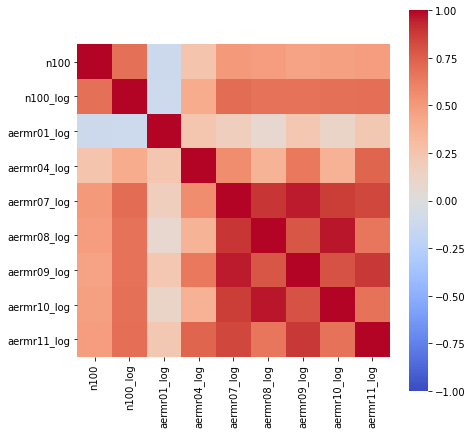

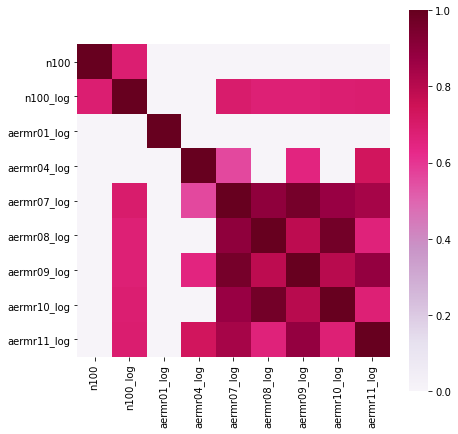

In [84]:
predictors = predictors_a

corr = data[['n100', 'n100_log']+predictors].corr()

plt.figure(figsize=(7, 7))
sns.heatmap(corr, xticklabels=['n100', 'n100_log']+predictors, yticklabels=['n100', 'n100_log']+predictors, 
            cmap='coolwarm', cbar=True, square=True, vmin=-1, vmax=1)

corr_coll = np.abs(corr)
corr_coll[corr_coll < 0.5] = 0
plt.figure(figsize=(7, 7))
sns.heatmap(corr_coll, xticklabels=['n100', 'n100_log']+predictors, yticklabels=['n100', 'n100_log']+predictors, 
            cmap='PuRd', cbar=True, square=True, vmin=0, vmax=1);

# Linear Regression

In [87]:
log_transf_n100 = True
predictors = predictors_b1

r2_log_all, rmse_log_all, log_predictions_all = [], [], []

# training the model using data for one station and testing the model on data of one other station
for train_station in cities:
    print(train_station)
    r2_log_ts, rmse_log_ts, log_predictions_ts = [], [], []
    
    for test_station in cities:
        # creating the train and test sets
        train_indices, test_indices = select_indices_station(data, train_station, test_station)
        tr_te_sets = make_train_test_sets(data, predictors, train_indices, test_indices, log_transf_n100)
        X_train, X_test, y_train, y_test, log_y_test, orig_y_test = tr_te_sets

        # linear regression model
        model = LinearRegression().fit(X_train, y_train)

        # making test set predictions
        predictions = model.predict(X_test)
        log_predictions = None
        if log_transf_n100:
            predictions[predictions <= 0] = 0
            log_predictions = predictions
            predictions = np.exp(predictions)
            predictions[predictions <= 1] = 1
        else:
            predictions[predictions <= 1] = 1
            log_predictions = np.log(predictions)

        # evaluating the model performance
        r2, r2_log, rmsle, rmse_log = eval_model(predictions, log_predictions, orig_y_test, log_y_test)
        r2_log_ts.append(r2_log)
        rmse_log_ts.append(rmse_log)
        log_predictions_ts.append(log_predictions)
        
    r2_log_all.append(r2_log_ts)
    rmse_log_all.append(rmse_log_ts)
    log_predictions_all.append(log_predictions_ts)

r2_log_all = np.array(r2_log_all)
rmse_log_all = np.array(rmse_log_all)
log_predictions_all = np.array(log_predictions_all)

ABZ
ALE
AMA
AMM
ASP
BEI
BOT
BSL
DEL
EGB
FKL
HAD
HEL
HPB
HRW
HYY
KCE
KPZ
MAR
MHD
MLP
MUK
NAN
NEU
POV
PRL
SAO
SCH
SGP
UAE
VAR
VHL
VIE
WAL
ZOT


C:\Users\ellar\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\ellar\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


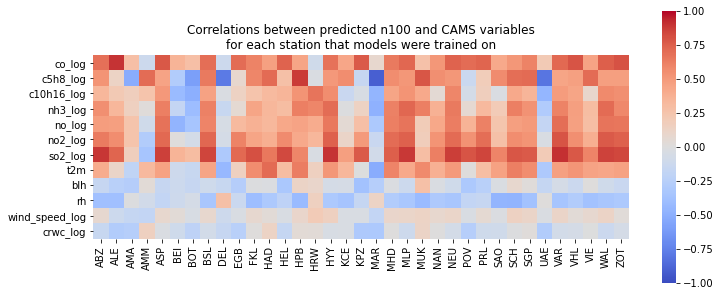

In [88]:
pred_n100_corrs = []
for i in range(len(cities)):
    test_data = data[predictors]
    test_data.loc[:,'predicted_n100'] = np.concatenate(log_predictions_all[i])
    test_data = test_data[['predicted_n100']+predictors]
    pred_n100_corrs.append(test_data.corr()['predicted_n100'].iloc[1:])

plt.figure(figsize=(12, 5))        
sns.heatmap(np.array(pred_n100_corrs).T, xticklabels=cities, yticklabels=predictors, 
            cmap='coolwarm', cbar=True, square=True, vmin=-1, vmax=1)
plt.title('Correlations between predicted n100 and CAMS variables\nfor each station that models were trained on');

In [10]:
cities_c2 = ['BOT', 'MAR', 'UAE', 'HPB', 'VIE', 'AMM', 'ZOT', 'SGP', 'VAR', 
             'EGB', 'MUK', 'BEI', 'SCH', 'HYY', 'MHD', 'ASP', 'VHL', 'HEL', 
             'NEU', 'WAL', 'SAO', 'MLP', 'KCE', 'KPZ', 'POV', 'ABZ', 'BSL', 
             'DEL', 'PRL', 'AMA', 'NAN', 'HAD', 'FKL', 'HRW', 'ALE']

r2_rearranged = []
for c1 in cities_c2:
    r2_rear = []
    for c2 in cities_c2:
        r2_rear.append(r2_log_all[cities.index(c1), cities.index(c2)])
    r2_rearranged.append(r2_rear)
    
rmse_rearranged = []
for c1 in cities_c2:
    rmse_rear = []
    for c2 in cities_c2:
        rmse_rear.append(rmse_log_all[cities.index(c1), cities.index(c2)])
    rmse_rearranged.append(rmse_rear)

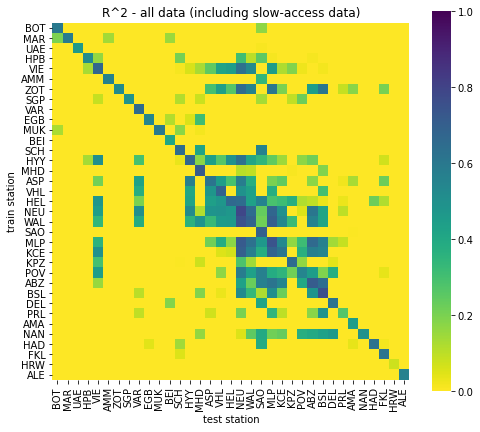

In [11]:
plt.figure(figsize=(8, 7))
sns.heatmap(r2_rearranged, xticklabels=cities_c2, yticklabels=cities_c2, 
            cmap='viridis_r', cbar=True, square=True, vmin=0, vmax=1)
plt.xlabel('test station')
plt.ylabel('train station')
plt.title('R^2 - all data (including slow-access data)');

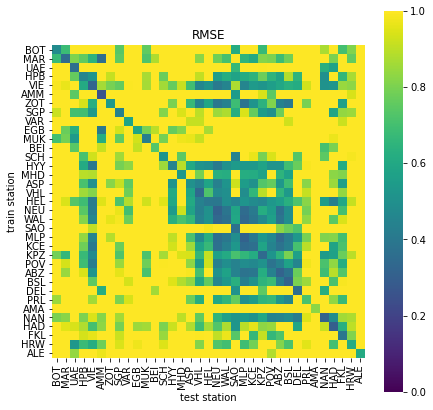

In [12]:
plt.figure(figsize=(7, 7))
sns.heatmap(rmse_rearranged, xticklabels=cities_c2, yticklabels=cities_c2, 
            cmap='viridis', cbar=True, square=True, vmin=0, vmax=1)
plt.xlabel('test station')
plt.ylabel('train station')
plt.title('RMSE');

# Old

Correlation between observed and predicted n100 concentration: 0.698
Correlation between observed and predicted n100 concentration (log-transformed): 0.766
R2 value on test set: 0.470700
R2 value on test set (log-transformed): 0.550300
RMSLE on test set: 0.792000
RMSE on test set (log_transformed): 0.817100


(0.4707, 0.5503, 0.792, 0.8171)

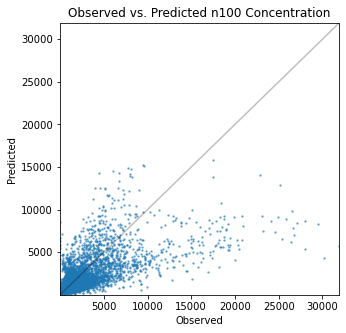

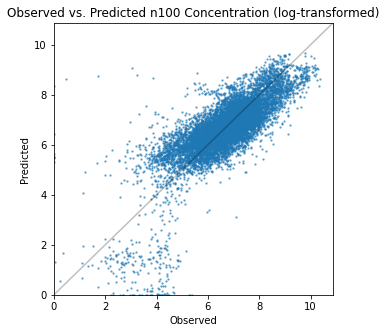

In [8]:
corr_eval(np.array(all_predictions), np.array(all_observations))
corr_eval(np.array(all_log_predictions), np.array(all_log_observations), log_transf=True)
eval_model(all_predictions, all_log_predictions, all_observations, all_log_observations, print_results=True)

Model equation:
n100_log = 0.0*aermr01 + 0.0*aermr02 + 0.0*aermr03 + 0.0*aermr04_log + 0.0*aermr05_log + 0.0*aermr06_log + 0.0*aermr07_log + 0.0*aermr08_log + 0.0*aermr09_log + 0.0*aermr10_log + 0.143*aermr11_log + 0.629*co_log + 0.0*c5h8_log + 0.018*c10h16_log + 0.041*nh3_log + 0.0*no_log + 0.0*no2_log + 0.075*so2_log + 0.007*t2m + 0.0*blh + 0.005*rh + 0.0*crwc_log + 19.796

Correlation between observed and predicted n100 concentration: 0.743
Correlation between observed and predicted n100 concentration (log-transformed): 0.75
R2 value on test set: 0.508600
R2 value on test set (log-transformed): 0.542900
RMSLE on test set: 0.760800
RMSE on test set (log_transformed): 0.763900


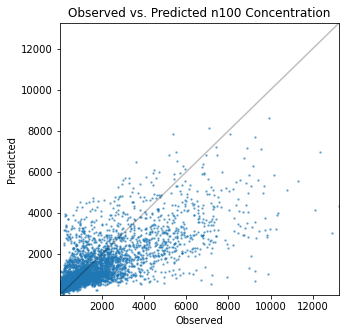

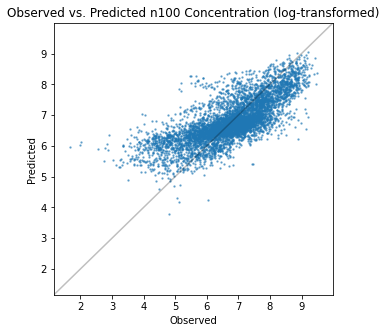

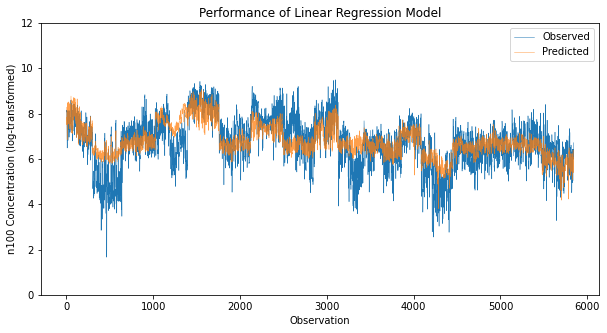

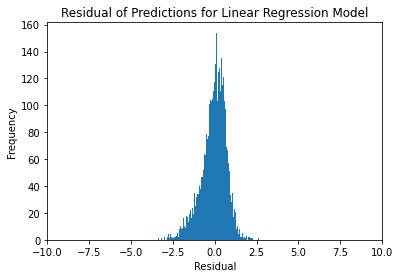

In [9]:
log_transf_n100 = True
train_indices, test_indices = select_indices_percent(data, train_frac=0.5, shuffle=False)
tr_te_sets = make_train_test_sets(data, predictors, train_indices, test_indices, log_transf_n100)
X_train, X_test, y_train, y_test, log_y_test, orig_y_test = tr_te_sets

# sklearn linear regression model using training set
model = LinearRegression(positive=True).fit(X_train, y_train)

# making test set predictions
predictions = model.predict(X_test)
log_predictions = None
if log_transf_n100:
    predictions[predictions <= 0] = 0
    log_predictions = predictions
    predictions = np.exp(predictions)
    predictions[predictions <= 1] = 1
else:
    predictions[predictions <= 1] = 1
    log_predictions = np.log(predictions)

# printing the model evaluation
print_equation(model, predictors)

# plotting observed vs. predicted n100 concentrations
corr_eval(predictions, orig_y_test)
corr_eval(log_predictions, log_y_test, log_transf=True)

# evaluating the model performance
r2, r2_log, rmsle, rmse_log = eval_model(predictions, log_predictions, orig_y_test, log_y_test, print_results=True)

# plotting the observed and predicted n100 concentrations against time in log-scale
plot_results('Linear Regression', log_predictions)
plot_residuals('Linear Regression', log_predictions)

# Random Forest Regression

Correlation between observed and predicted n100 concentration: 0.559
Correlation between observed and predicted n100 concentration (log-transformed): 0.73
R2 value on test set: 0.106600
R2 value on test set (log-transformed): 0.454800
RMSLE on test set: 0.824400
RMSE on test set (log_transformed): 0.827400


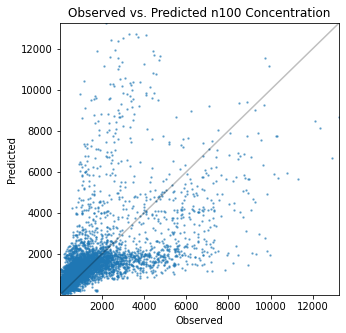

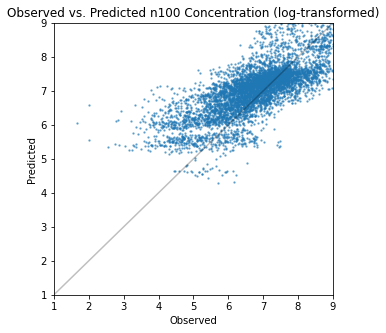

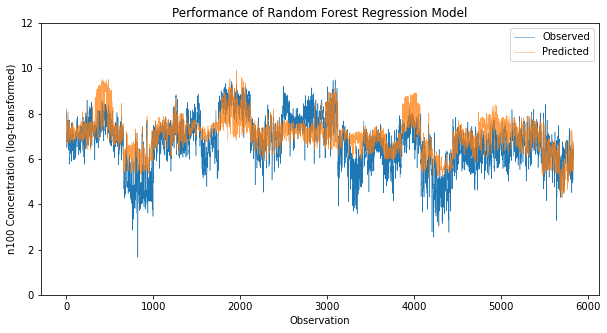

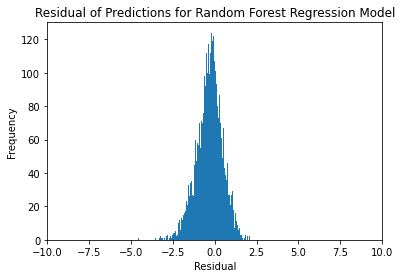

In [11]:
log_transf_n100 = False
train_indices, test_indices = select_indices_percent(data, train_frac=0.5, shuffle=False)
tr_te_sets = make_train_test_sets(data, all_vars, train_indices, test_indices, log_transf_n100)
X_train, X_test, y_train, y_test, log_y_test, orig_y_test = tr_te_sets

# fitting the random forest regression model
model = RandomForestRegressor(max_depth=10).fit(X_train, y_train)

# making test set predictions
predictions = model.predict(X_test)
log_predictions = None
if log_transf_n100:
    predictions[predictions <= 0] = 0
    log_predictions = predictions
    predictions = np.exp(predictions)
    predictions[predictions <= 1] = 1
else:
    predictions[predictions <= 1] = 1
    log_predictions = np.log(predictions)

# plotting observed vs. predicted n100 concentrations
corr_eval(predictions, orig_y_test)
corr_eval(log_predictions, log_y_test, log_transf=True)

# evaluating the model performance
eval_model(predictions, log_predictions, orig_y_test, log_y_test, print_results=True)

        
# plotting the observed and predicted n100 concentrations against time
plot_results('Random Forest Regression', log_predictions)
plot_residuals('Random Forest Regression', log_predictions)